# Test the sensitivity of the results to 3 factors: 

- Time scale of restoring source: compare 1year, 6year and corrected values.
- Spatial scale of coarsening: 25, 50, 100, 200km
- Influence of choosing tracers (this has been put in a separate notebook). 
- We are assuming that the 20 year average is long, and equilibrated. One could test influence of changing this, but not sure if it matters here. 

The error will be evaluated by looking at the PDFs of $\mathbf{u}'b$ and $\nabla.(\mathbf{u}'b)$. One could also look at the percentiles (25, 50(median), 75) for getting single numbers. 

The reason we are looking at buoyancy is because it is the only tracer without an interior source. For the other tracers, obviously, the fast restoring would be more appropriate for tracers that were restored fast, and vice versa. 

In [1]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
from funcs import *
import os 
from xgcm import Grid, generate_grid_ds

In [152]:
colors = ['R', 'b', 'g', 'k']
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [2]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [3]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [63]:
def flux_reconstruct(tensor, flux, grads, grid, Lcoarse):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)
    
    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    divUpCp = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
             -grid.interp(grid.diff(flux.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
            
    divUpCphor = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend')    
        
    divUpCpver = -grid.interp(grid.diff(flux.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
    
    dzUpCp = -grid.interp(grid.diff(flux.UpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/flux.drF + \
             -grid.interp(grid.diff(flux.VpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/flux.drF

    divrecflux = grid.interp(grid.diff(recUflux, 'X')/Lcoarse, 'X') + \
                 grid.interp(grid.diff(recVflux, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
                -grid.interp(grid.diff(recWflux, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
            
    divrecfluxhor = grid.interp(grid.diff(recUflux, 'X')/Lcoarse, 'X') + \
                 grid.interp(grid.diff(recVflux, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') 
        
    divrecfluxver = -grid.interp(grid.diff(recWflux, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
    
    dzrecflux = -grid.interp(grid.diff(recUflux, 'Z', boundary='extend'), 'Z', boundary='extend')/flux.drF + \
                -grid.interp(grid.diff(recVflux, 'Z', boundary='extend'), 'Z', boundary='extend')/flux.drF

    
    errdiv = np.abs(divUpCp - divrecflux)/np.abs(divUpCp)
    errdivhor = np.abs(divUpCphor - divrecfluxhor)/np.abs(divUpCphor)    
    errdivver = np.abs(divUpCpver - divrecfluxver)/np.abs(divUpCpver)
    errdzflux = np.abs(dzUpCp - dzrecflux)/np.abs(dzUpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW, 
                         'divrecflux': divrecflux, 'divUpCp': divUpCp, 
                         'errdiv':errdiv, 'errdivhor':errdivhor,'errdivver':errdivver,'errdzflux':errdzflux})
    
    return flux_rec

In [64]:
Lcoarselist = [25e3, 50e3, 100e3, 200e3]

In [129]:
frb_temp = {}
frb_fast = {}
frb_slow = {}
mask = {}

In [130]:
Lcoarse = 50e3

In [131]:
# load data
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km.nc')

mask[Lcoarse] = Trac_coarse.hFacCcoarse
# compute fluxes and gradients
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})

# define a grid for taking gradients on coarse grid
grid_ds = xr.Dataset()
grid_ds['TRAC01'] = Trac_coarse['TRAC01']
grid_ds['wVeltave'] = Model_Tav['wVeltave']
grid_ds = grid_ds.drop(['wVeltave','XC','YC']).isel(XC=0, YC=0)
ds = generate_grid_ds(grid_ds, {'X': 'XCcoarse', 'Y':'YCcoarse'})
grid = Grid(ds, periodic='X')

frb_temp[Lcoarse] = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT, grid, Lcoarse)
frb_fast[Lcoarse] = flux_reconstruct(diff_tensor.Kfast, flux.sel(tracer_num=slice(1,19,2)), grads.sel(tracer_num=slice(1,19,2)), grid, Lcoarse)
frb_slow[Lcoarse] = flux_reconstruct(diff_tensor.Kslow, flux.sel(tracer_num=slice(2,20,2)), grads.sel(tracer_num=slice(2,20,2)), grid, Lcoarse)

In [134]:
frb_tracer = {}
frb_tracer[1] = flux_reconstruct(diff_tensor.Kfast, flux.sel(tracer_num=1), grads.sel(tracer_num=1), grid, Lcoarse)

In [136]:
for i in range(1,21,2):
    print(i)
    frb_tracer[i] = flux_reconstruct(diff_tensor.Kfast, flux.sel(tracer_num=i), grads.sel(tracer_num=i), grid, Lcoarse)
    
for i in range(2,22,2):
    print(i)
    frb_tracer[i] = flux_reconstruct(diff_tensor.Kslow, flux.sel(tracer_num=i), grads.sel(tracer_num=i), grid, Lcoarse)

1
3
5
7
9
11
13
15
17
19
2
4
6
8
10
12
14
16
18
20


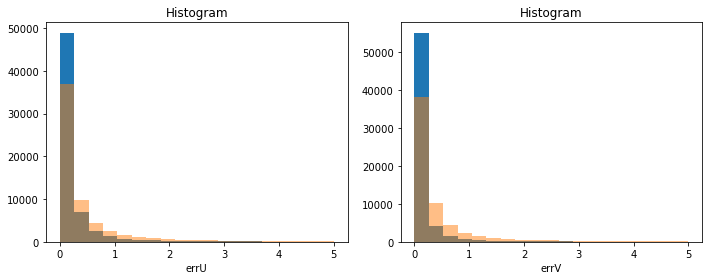

In [86]:
plt.figure(figsize=(10,4))
plt.subplot(121)
bins= np.linspace(0,5,20)
[_,_,_] = frb_fast[50e3].errU.sel(tracer_num=1).plot.hist(bins=bins)
[_,_,_] = frb_temp[50e3].errU.plot.hist(bins=bins, alpha=0.5)

plt.subplot(122)
bins= np.linspace(0,5,20)
[_,_,_] = frb_fast[50e3].errV.sel(tracer_num=1).plot.hist(bins=bins)
[_,_,_] = frb_temp[50e3].errV.plot.hist(bins=bins, alpha=0.5)

plt.tight_layout()

In [138]:
frb_tracer[1]

<xarray.Dataset>
Dimensions:      (XCcoarse: 40, YCcoarse: 40, Z: 40)
Coordinates:
  * Z            (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
  * YCcoarse     (YCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
  * XCcoarse     (XCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
    hFacCcoarse  (Z, YCcoarse, XCcoarse) float32 0.9 0.9 0.9 0.9 ... 1.0 1.0 1.0
    PHrefC       (Z) float32 49.05 147.15 245.25 ... 27767.205 28777.635
    drF          (Z) float32 10.0 10.0 10.0 12.0 ... 103.0 103.0 103.0 103.0
    tracer_num   int64 1
Data variables:
    UpCp         (Z, YCcoarse, XCcoarse) float32 -0.00030903937 ... -0.0006404739
    VpCp         (Z, YCcoarse, XCcoarse) float32 -0.00016258014 ... -6.293407e-05
    WpCp         (Z, YCcoarse, XCcoarse) float32 -1.07114204e-07 ... 8.5983665e-11
    errU         (Z, YCcoarse, XCcoarse) float32 0.123968415 ... 0.52775
    errV         (Z, YCcoarse, XCcoarse) float32 0.12537076 ... 0.087900594
    errW         

(0, 24)

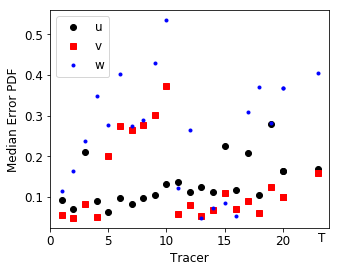

In [154]:
plt.figure(figsize=(5,4))
plt.plot(i, frb_tracer[i].errU.sel(YCcoarse=slice(0,1800e3)).median(), 'o', color='k', label='u')
plt.plot(i, frb_tracer[i].errV.sel(YCcoarse=slice(0,1800e3)).median(), 's', color='r', label='v')
plt.plot(i, frb_tracer[i].errW.sel(YCcoarse=slice(0,1800e3)).median(), '.', color='b', label='w')
plt.legend()

for i in range(1,21,1):
    plt.plot(i, frb_tracer[i].errU.sel(YCcoarse=slice(0,1800e3)).median(), 'o', color='k')
    plt.plot(i, frb_tracer[i].errV.sel(YCcoarse=slice(0,1800e3)).median(), 's', color='r')
    plt.plot(i, frb_tracer[i].errW.sel(YCcoarse=slice(0,1800e3)).median(), '.', color='b')


plt.plot(23, frb_temp[50e3].errU.sel(YCcoarse=slice(0,1800e3)).median(), 'o', color='k', label='u')
plt.plot(23, frb_temp[50e3].errV.sel(YCcoarse=slice(0,1800e3)).median(), 's', color='r', label='v')
plt.plot(23, frb_temp[50e3].errW.sel(YCcoarse=slice(0,1800e3)).median(), '.', color='b', label='w')
plt.text(23, -0.01, 'T', fontsize=12)    
    
plt.xlabel('Tracer')
plt.ylabel('Median Error PDF')
plt.xlim([0,24])


#### play with one tracer avg scale

In [35]:
def flux_reconstruct_corrs(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)
    
    corrU = (flux.UpCp * recUflux).mean() / ((flux.UpCp**2).mean() * (recUflux**2).mean())**0.5
    corrV = (flux.VpCp * recVflux).mean() / ((flux.VpCp**2).mean() * (recVflux**2).mean())**0.5
    corrW = (flux.WpCp * recWflux).mean() / ((flux.WpCp**2).mean() * (recWflux**2).mean())**0.5
    
    corrU_pearson = ((flux.UpCp-flux.UpCp.mean()) * (recUflux-recUflux.mean())
                    ).mean() / (((flux.UpCp-flux.UpCp.mean())**2).mean() * ((recUflux-recUflux.mean())**2).mean())**0.5
    
    corrV_pearson = ((flux.VpCp-flux.VpCp.mean()) * (recVflux-recVflux.mean())
                    ).mean() / (((flux.VpCp-flux.VpCp.mean())**2).mean() * ((recVflux-recVflux.mean())**2).mean())**0.5
    
    corrW_pearson = ((flux.WpCp-flux.WpCp.mean()) * (recWflux-recWflux.mean())
                    ).mean() / (((flux.WpCp-flux.WpCp.mean())**2).mean() * ((recWflux-recWflux.mean())**2).mean())**0.5
    
    
    
    #flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
    #                            'errU':errU, 'errV':errV, 'errW':errW, 
    #                     'divrecflux': divrecflux, 'divUpCp': divUpCp, 
    #                     'errdiv':errdiv, 'errdivhor':errdivhor,'errdivver':errdivver,'errdzflux':errdzflux})
    
    corrs = xr.Dataset({'corrU':corrU, 'corrV':corrV, 'corrW':corrW, 
                      'corrU_pearson':corrU_pearson, 'corrV_pearson':corrV_pearson, 'corrW_pearson':corrW_pearson})
    
    return corrs

In [36]:
Lcoarse = 50e3
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km.nc')

mask[Lcoarse] = Trac_coarse.hFacCcoarse
# compute fluxes and gradients
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})

In [140]:
corrs = {}
i=1
corrs[i] = flux_reconstruct_corrs(diff_tensor.Kfast.sel(YCcoarse=slice(0,1800e3)), flux.sel(tracer_num=i).sel(YCcoarse=slice(0,1800e3)),
                                  grads.sel(tracer_num=i).sel(YCcoarse=slice(0,1800e3)))

In [141]:
for i in range(1,21,2):
    print(i)
    corrs[i] = flux_reconstruct_corrs(diff_tensor.Kfast, flux.sel(tracer_num=i).sel(YCcoarse=slice(0,1800e3)), 
                                      grads.sel(tracer_num=i).sel(YCcoarse=slice(0,1800e3)))
    
for i in range(2,22,2):
    print(i)
    corrs[i] = flux_reconstruct_corrs(diff_tensor.Kslow, flux.sel(tracer_num=i).sel(YCcoarse=slice(0,1800e3)), 
                                      grads.sel(tracer_num=i).sel(YCcoarse=slice(0,1800e3)))

1
3
5
7
9
11
13
15
17
19
2
4
6
8
10
12
14
16
18
20


In [114]:
corrs

{1: <xarray.Dataset>
 Dimensions:        ()
 Coordinates:
     tracer_num     int64 1
 Data variables:
     corrU          float32 0.98302466
     corrV          float32 0.9962587
     corrW          float32 0.9932083
     corrU_pearson  float32 0.9831179
     corrV_pearson  float32 0.9951564
     corrW_pearson  float32 0.9914733, 3: <xarray.Dataset>
 Dimensions:        ()
 Coordinates:
     tracer_num     int64 3
 Data variables:
     corrU          float32 0.9458416
     corrV          float32 0.9912383
     corrW          float32 0.98343253
     corrU_pearson  float32 0.94477713
     corrV_pearson  float32 0.991272
     corrW_pearson  float32 0.9830738, 5: <xarray.Dataset>
 Dimensions:        ()
 Coordinates:
     tracer_num     int64 5
 Data variables:
     corrU          float32 0.9812992
     corrV          float32 0.9578353
     corrW          float32 0.93990505
     corrU_pearson  float32 0.9801184
     corrV_pearson  float32 0.95776856
     corrW_pearson  float32 0.93771845, 7

(0, 21)

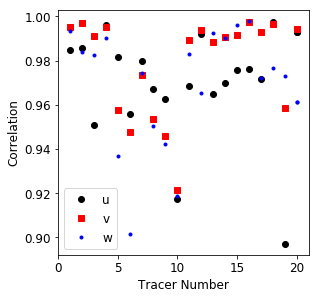

In [155]:

plt.plot(i, corrs[i].corrU_pearson, 'o', color='k', label='u')
plt.plot(i, corrs[i].corrV_pearson, 's', color='r', label='v')
plt.plot(i, corrs[i].corrW_pearson, '.', color='b', label='w')
plt.legend()

for i in range(1,21,1):
    plt.plot(i, corrs[i].corrU_pearson, 'o', color='k')
    plt.plot(i, corrs[i].corrV_pearson, 's', color='r')
    plt.plot(i, corrs[i].corrW_pearson, '.', color='b')

plt.xlabel('Tracer Number')
plt.ylabel('Correlation')
plt.xlim([0,21])


In [174]:
corrs_temp = flux_reconstruct_corrs(diff_tensor.Kcorr, fluxT.sel(YCcoarse=slice(0,1800e3)), gradT.sel(YCcoarse=slice(0,1800e3)))

In [175]:
corrs_temp

<xarray.Dataset>
Dimensions:        ()
Data variables:
    corrU          float32 0.92377913
    corrV          float32 0.973769
    corrW          float32 0.9461668
    corrU_pearson  float32 0.92422456
    corrV_pearson  float32 0.973186
    corrW_pearson  float32 0.93472666

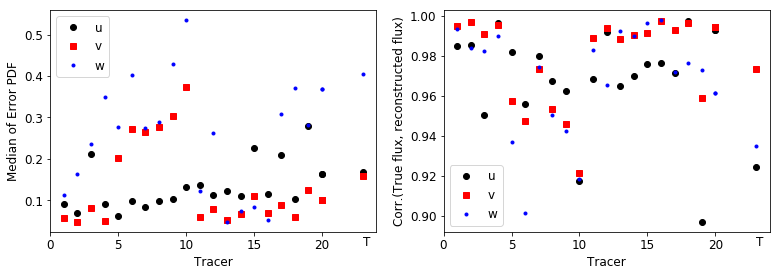

In [170]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(i, frb_tracer[i].errU.sel(YCcoarse=slice(0,1800e3)).median(), 'o', color='k', label='u')
plt.plot(i, frb_tracer[i].errV.sel(YCcoarse=slice(0,1800e3)).median(), 's', color='r', label='v')
plt.plot(i, frb_tracer[i].errW.sel(YCcoarse=slice(0,1800e3)).median(), '.', color='b', label='w')
plt.legend()

for i in range(1,21,1):
    plt.plot(i, frb_tracer[i].errU.sel(YCcoarse=slice(0,1800e3)).median(), 'o', color='k')
    plt.plot(i, frb_tracer[i].errV.sel(YCcoarse=slice(0,1800e3)).median(), 's', color='r')
    plt.plot(i, frb_tracer[i].errW.sel(YCcoarse=slice(0,1800e3)).median(), '.', color='b')


plt.plot(23, frb_temp[50e3].errU.sel(YCcoarse=slice(0,1800e3)).median(), 'o', color='k', label='u')
plt.plot(23, frb_temp[50e3].errV.sel(YCcoarse=slice(0,1800e3)).median(), 's', color='r', label='v')
plt.plot(23, frb_temp[50e3].errW.sel(YCcoarse=slice(0,1800e3)).median(), '.', color='b', label='w')
plt.text(23, -0.01, 'T', fontsize=12)    
    
plt.xlabel('Tracer')
plt.ylabel('Median of Error PDF')
plt.xlim([0,24])

plt.subplot(122)
plt.plot(i, corrs[i].corrU_pearson, 'o', color='k', label='u')
plt.plot(i, corrs[i].corrV_pearson, 's', color='r', label='v')
plt.plot(i, corrs[i].corrW_pearson, '.', color='b', label='w')
plt.legend()

for i in range(1,21,1):
    plt.plot(i, corrs[i].corrU_pearson, 'o', color='k')
    plt.plot(i, corrs[i].corrV_pearson, 's', color='r')
    plt.plot(i, corrs[i].corrW_pearson, '.', color='b')

plt.plot(23, corrs_temp.corrU_pearson, 'o', color='k')
plt.plot(23, corrs_temp.corrV_pearson, 's', color='r')
plt.plot(23, corrs_temp.corrW_pearson, '.', color='b')
plt.text(23, 0.885, 'T', fontsize=12)    

plt.xlabel('Tracer')
plt.ylabel('Corr.(True flux, reconstructed flux)')
plt.xlim([0,24])

plt.tight_layout()

plt.savefig('errors.pdf')

In [8]:
bins = np.linspace(0,30,300)
colors = ['R', 'b', 'g', 'k']
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be remov

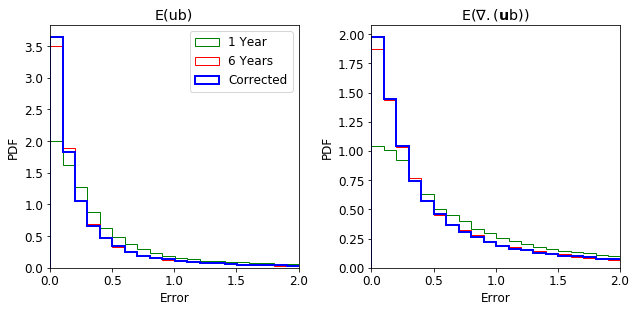

In [13]:
plt.figure(figsize=(9,4.5))
Lcoarse = 50e3

plt.subplot(122)

frb_fast[Lcoarse].errdiv.where(mask[Lcoarse]==1).sel(YCcoarse=slice(0,1800e3)).plot.hist(bins=bins, normed=True,
             histtype='step',edgecolor= 'g', linewidth=1, fill=False, label = '1 Year')
frb_slow[Lcoarse].errdiv.where(mask[Lcoarse]==1).sel(YCcoarse=slice(0,1800e3)).plot.hist(bins=bins, normed=True,
             histtype='step',edgecolor= 'r', linewidth=1, fill=False, label = '6 Years')
frb_corr[Lcoarse].errdiv.where(mask[Lcoarse]==1).sel(YCcoarse=slice(0,1800e3)).plot.hist(bins=bins, normed=True,
             histtype='step',edgecolor= 'b', linewidth=2, fill=False, label = 'Corrected')

plt.xlim([0,2])
plt.title(r'E($\nabla.(\mathbf{u}$b))')
plt.xlabel('Error')
plt.ylabel('PDF')

plt.subplot(121)

frb_fast[Lcoarse].errU.where(mask[Lcoarse]==1).sel(YCcoarse=slice(0,1800e3)).plot.hist(bins=bins, normed=True,
             histtype='step',edgecolor= 'g', linewidth=1, fill=False, label = '1 Year')
frb_slow[Lcoarse].errU.where(mask[Lcoarse]==1).sel(YCcoarse=slice(0,1800e3)).plot.hist(bins=bins, normed=True,
             histtype='step',edgecolor= 'r', linewidth=1, fill=False, label = '6 Years')
frb_corr[Lcoarse].errU.where(mask[Lcoarse]==1).sel(YCcoarse=slice(0,1800e3)).plot.hist(bins=bins, normed=True,
             histtype='step',edgecolor= 'b', linewidth=2, fill=False, label = 'Corrected')

plt.xlim([0,2])
plt.legend()
plt.title(r'E(ub)')
plt.xlabel('Error')
plt.ylabel('PDF')
plt.tight_layout()
plt.savefig('fig2c.pdf', dpi=200,bbox_inches='tight')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/dbalwada/.conda/envs/pangeo/lib/py

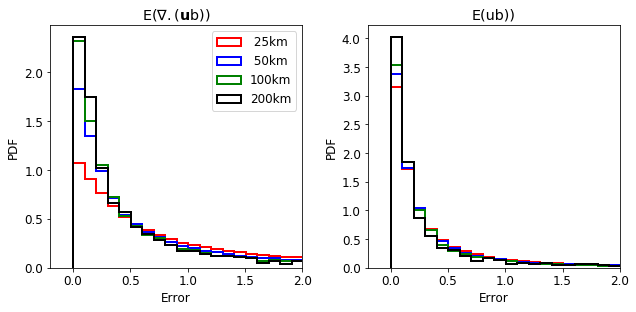

In [137]:
plt.figure(figsize=(9,4.5))
n=0
for Lcoarse in Lcoarselist:
    plt.subplot(121)
    frb_corr[Lcoarse].errdiv.where(mask[Lcoarse]==1).plot.hist(bins=bins, density=True,
                         histtype='step',edgecolor= colors[n], linewidth=2, fill=False, label = str('%3.0f' %(Lcoarse/1e3))+'km')

    plt.subplot(122)
    frb_corr[Lcoarse].errU.where(mask[Lcoarse]==1).plot.hist(bins=bins, density=True,
                         histtype='step',edgecolor= colors[n], linewidth=2, fill=False, label = str('%3.0f' %(Lcoarse/1e3))+'km')

    n+=1
    
plt.subplot(121)
plt.xlim([-0.2,2])
plt.legend()
plt.title(r'E($\nabla.(\mathbf{u}$b))')
plt.xlabel('Error')
plt.ylabel('PDF')

plt.subplot(122)
plt.xlim([-0.2,2])
plt.title(r'E(ub))')
plt.xlabel('Error')
plt.ylabel('PDF')
plt.tight_layout()


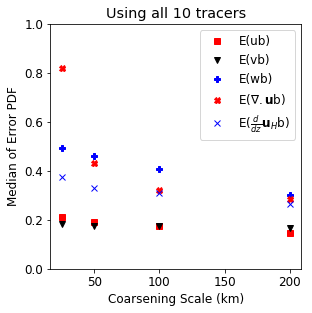

In [9]:
for Lcoarse in Lcoarselist: 
    temp = frb_corr[Lcoarse]
    hFacCcoarse = mask[Lcoarse]
    
    if Lcoarse == 25e3 :
        
        plt.plot(Lcoarse/1e3, temp.errU.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']),
                 'rs', label='E(ub)')
        plt.plot(Lcoarse/1e3, temp.errV.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'kv', label='E(vb)')
        plt.plot(Lcoarse/1e3, temp.errW.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bP', label='E(wb)')

        plt.plot(Lcoarse/1e3, temp.errdiv.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'rX', label=r'E($\nabla.\mathbf{u}$b)')
        plt.plot(Lcoarse/1e3, temp.errdzflux.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx', label=r'E($\frac{d}{dz}\mathbf{u}_H$b)')        
#        plt.plot(Lcoarse/1e3, temp.errdivhor.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx', label=r'E($\nabla_H.\mathbf{u}_H$b)')
#        plt.plot(Lcoarse/1e3, temp.errdivver.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bh', label=r'E($\nabla_z.\mathbf{u}_z$b)')
    else:
        plt.plot(Lcoarse/1e3, temp.errU.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'rs')
        plt.plot(Lcoarse/1e3, temp.errV.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'kv')
        plt.plot(Lcoarse/1e3, temp.errW.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bP')

        plt.plot(Lcoarse/1e3, temp.errdiv.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'rX')
        plt.plot(Lcoarse/1e3, temp.errdzflux.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx')   
#        plt.plot(Lcoarse/1e3, temp.errdivhor.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx')   
#        plt.plot(Lcoarse/1e3, temp.errdivver.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bh')
        
        
plt.legend(loc='best')    
plt.xlabel('Coarsening Scale (km)')
plt.ylabel('Median of Error PDF')
plt.title('Using all 10 tracers')
plt.ylim([0,1])      
#plt.savefig('fig2b.pdf', dpi=200,bbox_inches='tight')

In [139]:
for Lcoarse in Lcoarselist: 
    temp = frb_corr[Lcoarse]
    hFacCcoarse = mask[Lcoarse]
    
    if Lcoarse == 25e3 :
        
        plt.plot(Lcoarse/1e3, temp.errU.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']),
                 'rs', label='E(ub)')
        plt.plot(Lcoarse/1e3, temp.errV.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'kv', label='E(vb)')
        plt.plot(Lcoarse/1e3, temp.errW.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'bP', label='E(wb)')

        plt.plot(Lcoarse/1e3, temp.errdiv.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'rX', label=r'E($\nabla.\mathbf{u}$b)')
        plt.plot(Lcoarse/1e3, temp.errdzflux.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'bx', label=r'E($\frac{d}{dz}\mathbf{u}_H$b)')        
#        plt.plot(Lcoarse/1e3, temp.errdivhor.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx', label=r'E($\nabla_H.\mathbf{u}_H$b)')
#        plt.plot(Lcoarse/1e3, temp.errdivver.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bh', label=r'E($\nabla_z.\mathbf{u}_z$b)')
    else:
        plt.plot(Lcoarse/1e3, temp.errU.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'rs')
        plt.plot(Lcoarse/1e3, temp.errV.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'kv')
        plt.plot(Lcoarse/1e3, temp.errW.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'bP')

        plt.plot(Lcoarse/1e3, temp.errdiv.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'rX')
        plt.plot(Lcoarse/1e3, temp.errdzflux.where(hFacCcoarse==1.).sel(YCcoarse=slice(0,1800e3)).median(['XCcoarse', 'YCcoarse','Z']), 'bx')   
#        plt.plot(Lcoarse/1e3, temp.errdivhor.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bx')   
#        plt.plot(Lcoarse/1e3, temp.errdivver.where(hFacCcoarse==1.).median(['XCcoarse', 'YCcoarse','Z']), 'bh')
        
        
plt.legend(loc='best')    
plt.xlabel('Coarsening Scale (km)')
plt.ylabel('Median of Error PDF')
plt.title('Using all 10 tracers')
plt.ylim([0,1])      
#plt.savefig('fig2b.pdf', dpi=200,bbox_inches='tight')

KeyError: 25000.0